<a href="https://colab.research.google.com/github/voronv27/Lab1/blob/main/01_data_and_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Card

###Motivation

The motivation for using this datasheet is to predict based on smartphone sensor recordings what sort of movement a person is doing (i.e. walking, sitting, etc).

###Target Definition

We will predict a person's movement type out of 6 categories: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, and LAYING.

###Data Source

The data was downloaded from https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

and is licensed under a [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode) (CC BY 4.0) license.

Use of this dataset in publications must be acknowledged by referencing the following publication [1]

[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

This dataset is distributed AS-IS and no responsibility implied or explicit can be addressed to the authors or their institutions for its use or misuse. Any commercial use is prohibited.

###Signal Description

The HAR dataset has the following channels:

- total acceleration from the smartphone accelerometer in standard gravity units for the x, y, and z axis (total_acc_[x/y/z]_train.txt)

- body acceleration signal (subtracting gravity from total acceleration) for the x, y, and z axis (body_acc_[x/y/z].txt)

- the angular velocity measured by the gyroscope for each window sample in radians/second (body_gyro[x/y/z]_train.txt).


In total, this is 9 channels.

The sensor signals (accelerometer and gyroscope) were sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). This means each new window starts its reading after the previous window is halfway through its duration (2.56/2 = every 1.28 seconds).

###Limitations/Risks

Only a very small set of movements were recorded (walking, walking up/down stairs, standing, sitting, and laying), meaning the model will only be trained to characterize movements into one of those categories (as opposed to more complex movements such as running, dancing, falling, etc).

Only 30 subjects were sampled. This is a small amount of people so the data may not reflect the general public's movement patterns as well. As an example, the age range of the participants was from 19-48, meaning that the movement of children and the elderly wasn't taken into account and the model most likely wouldn't be able to predict their actions as accurately (ex: walking with a cane or more slowly due to age would also affect sensor data).

##Data Sanity Checks

In [164]:
import os, random
import numpy as np
import torch
def seed_everything(seed: int = 42):
 random.seed(seed)
 np.random.seed(seed)
 os.environ["PYTHONHASHSEED"] = str(seed)
 torch.manual_seed(seed)
 torch.cuda.manual_seed_all(seed)
 torch.backends.cudnn.benchmark = False
 torch.backends.cudnn.deterministic = True

In [165]:
# load data as torch tensor
import numpy as np
import torch

files = ['body_acc_x_train.txt',
         'body_acc_y_train.txt',
         'body_acc_z_train.txt',
         'body_gyro_x_train.txt',
         'body_gyro_y_train.txt',
         'body_gyro_z_train.txt',
         'total_acc_x_train.txt',
         'total_acc_y_train.txt',
         'total_acc_z_train.txt' ]

# data will be in shape (C, N, T)
x = []
for file in files:
    x.append(torch.from_numpy(np.loadtxt('Inertial_Signals/' + file)))

# convert to (N, T, C)
x = torch.stack(x).permute(1, 2, 0)

y = torch.from_numpy(np.loadtxt('y_train.txt'))

###Confirm Shapes

In [166]:
# print N (num windows), T (readings/window), C (num channels)
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: torch.Size([7352, 128, 9])
y shape: torch.Size([7352])


###Check Label Distribution

In [167]:
label_counts = torch.bincount(y.long())

activity_names = [
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
    "SITTING", "STANDING", "LAYING"
]

for i in range(0, len(activity_names)):
    label_name = activity_names[i]
    count = label_counts[i+1]
    percentage = (count / label_counts.sum()) * 100
    print(f"{label_name} count: {count}; percentage: {percentage:.2f}")

WALKING count: 1226; percentage: 16.68
WALKING_UPSTAIRS count: 1073; percentage: 14.59
WALKING_DOWNSTAIRS count: 986; percentage: 13.41
SITTING count: 1286; percentage: 17.49
STANDING count: 1374; percentage: 18.69
LAYING count: 1407; percentage: 19.14


There is a fairly even distribution for each activity, with the smallest amount for WALKING_DOWNSTAIRS and largest amount for LAYING.

###Check For Missing Values

In [168]:
print("Missing values:", torch.isnan(x).any())
print("Missing values:", torch.isnan(y).any())
print("Inf values:", torch.isinf(x).any())
print("Inf values:", torch.isinf(y).any())

Missing values: tensor(False)
Missing values: tensor(False)
Inf values: tensor(False)
Inf values: tensor(False)


As seen above, there are no missing values.

# Leakage Checks

###Implement Subject-Disjoint Split

In [169]:
from sklearn.model_selection import GroupShuffleSplit

groups = np.loadtxt('subject_train.txt')

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_indices, test_indices = next(gss.split(x, y, groups))

x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

###Show Overlap=0

In [170]:
# show that each subject in groups is in either train or test, not both

train_subjects = np.unique(groups[train_indices])
test_subjects = np.unique(groups[test_indices])

print("Train subjects:", train_subjects)
print("Test subjects:", test_subjects)
print(np.intersect1d(train_subjects, test_subjects))

Train subjects: [ 5.  6.  7.  8. 11. 14. 16. 17. 19. 21. 22. 23. 26. 28. 29. 30.]
Test subjects: [ 1.  3. 15. 25. 27.]
[]


So there is no overlap between the train and test subjects.

#MLP Baseline

###Baseline 0

We are using a majority class predictor, so our predictions are just the most common class in our train

In [171]:
majority_class = torch.bincount(y_train.long()).argmax()
print("Majority class is:", majority_class.item())

Majority class is: 6


In [172]:
class MajorityClassPredictor():
    def __init__(self, majority_class):
        self.majority_class = majority_class

    def predict(self, x):
        return torch.ones(x.shape[0]) * self.majority_class

In [173]:
naive_predictor = MajorityClassPredictor(majority_class.item())
y_pred = naive_predictor.predict(x_test)

In [174]:
from sklearn.metrics import accuracy_score

print(f"Accuracy of majority class predictor: {accuracy_score(y_test, y_pred):.4f}")

Accuracy of majority class predictor: 0.1838


###Baseline 1

MLP on flattened windows (T x C) with a train/validation split drawn only from the training subjects

In [175]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*9, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 6)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [176]:
import torch.nn.functional as F

# flatten x_train, x_test
x_train_flat = x_train.transpose(1,2).flatten(1).float()
x_test_flat = x_test.transpose(1,2).flatten(1).float()

# one-hot encode y_train, y_test
y_train_encoded = F.one_hot(y_train.long()- 1, num_classes=6).float()
y_test_encoded = F.one_hot(y_test.long()- 1, num_classes=6).float()

In [177]:
# function to initialize model (so we can test different hyperparams)
def initialize_model(lr=0.01):
  model = NeuralNetwork()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()
  return model, optimizer, loss_fn

In [198]:
# function to run batch gradient descent (so we can test different hyperparams)
def train_model(model, optimizer, loss_fn, epochs=50, batch_size=128, print_step=10):
  for ep in range(epochs):
    model.train() # put model in training mode

    # shuffle data
    shuffle = np.random.permutation(x_train_flat.shape[0])
    x_shuffle = x_train_flat[shuffle]
    y_shuffle = y_train_encoded[shuffle]

    # minibatch gradient descent
    for b in range(0, x_train.shape[0], batch_size):
      x_batch = x_shuffle[b:b + batch_size]
      y_batch = y_shuffle[b:b + batch_size]

      optimizer.zero_grad() # zero gradients
      y_pred = model(x_batch) # forward propagation

      loss = loss_fn(y_pred.double(), y_batch.double()) # compute loss

      loss.backward() # backward propagation
      optimizer.step() # update weights

    # evaluate on dev set
    model.eval() # put model in evaluation mode
    with torch.no_grad():
      y_pred = model(x_test_flat)
      loss = loss_fn(y_pred, y_test_encoded)

    if print_step and (ep % print_step == 0):
      print(f"Epoch {ep}, Loss: {loss.item()}")

In [200]:
model, optimizer, loss_fn = initialize_model()
train_model(model, optimizer, loss_fn, print_step=None)

###Report Metrics

We chose accuracy are our primary metric. As seen here, the accuracy score is much higher than our baseline 0 model which just predicted the majority class.

In [201]:
# Baseline 1 accuracy
model.eval()
with torch.no_grad():
  y_pred = model(x_test_flat)
  #accuracy = mean_percentage_error(y_test_encoded, y_pred, len(y_pred))
  accuracy = accuracy_score(y_test_encoded.argmax(dim=-1), y_pred.argmax(dim=-1))
  print(f"Accuracy score: {accuracy:.4f}")


Accuracy score: 0.8462


Confusion Matrix:

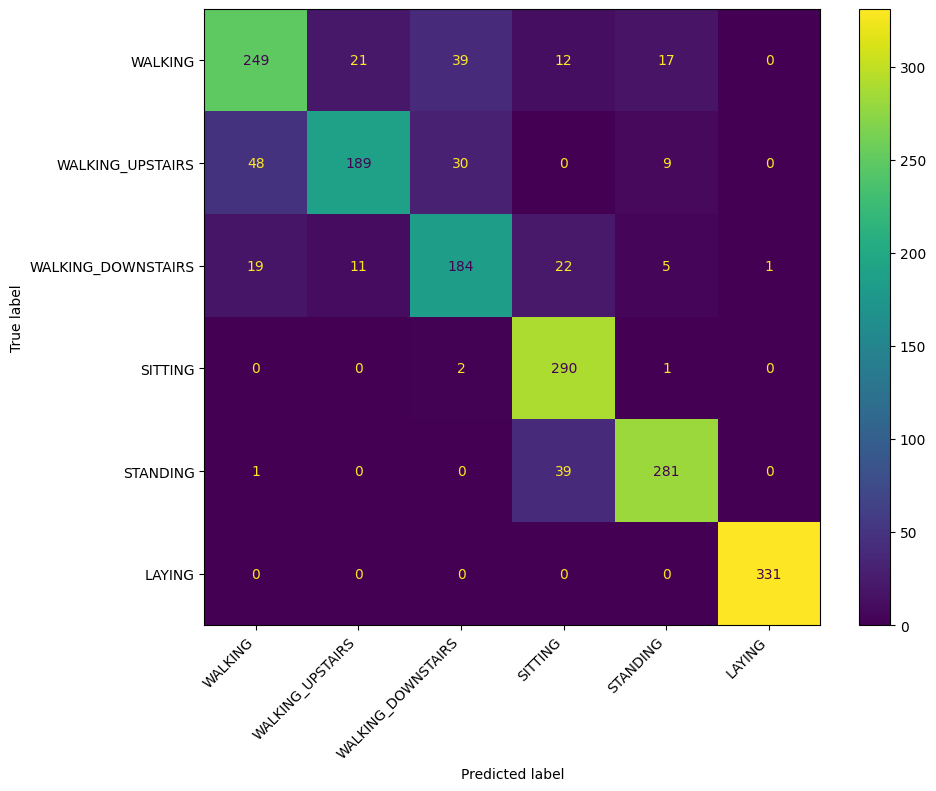

In [202]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(10, 8)) # Adjust figsize as needed

cm = confusion_matrix(y_test_encoded.argmax(dim=-1), y_pred.argmax(dim=-1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_names)

cm_display.plot(ax=ax)
# rotate activity names 45 degrees so they don't overlap
ax.set_xticklabels(activity_names, rotation=45, ha='right')
plt.show()